# Create a Siamese Network with Triplet Loss in Keras

# Task 1: Understanding the Approach

In [53]:
#matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.12.0


## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](assets/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Task 2: Importing the Data

In [54]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [55]:
x_train = np.reshape(x_train, (60000, 784))/255
x_test = np.reshape(x_test, (10000,784))/255

print(x_train.shape)

(60000, 784)


# Task 3: Plotting Examples

In [56]:
def plot_triplet(triplets):
    plt.figure(figsize=(6,2))
    for i in range(0, 3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(np.reshape(triplets[i], (28, 28)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

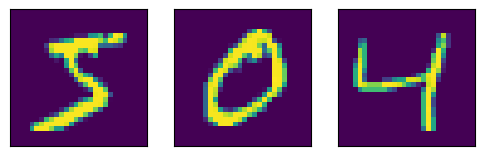

In [57]:
plot_triplet([x_train[0], x_train[1], x_train[2]])


# Task 4: A Batch of Triplets

In [58]:
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 784))
    positives = np.zeros((batch_size, 784))
    negatives = np.zeros((batch_size, 784))

    for i in range (0, batch_size):
        index = random.randint(0, 60000-1)
        anc = x_train[index]
        y = y_train[index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]

        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
    
    return(anchors, positives, negatives)

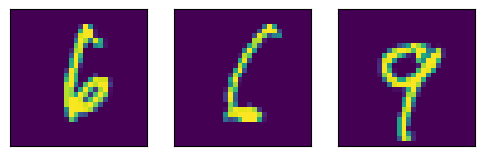

In [59]:
triplet = create_batch(1)
plot_triplet(triplet)

# Task 5: Embedding Model

In [60]:
emb_dim = 64

embedding_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape =(784,)),
    tf.keras.layers.Dense(emb_dim, activation= 'sigmoid')
])

embedding_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [61]:
example = x_train[0]
embedding_model.predict(np.expand_dims(example, axis=0))

1/1 [==============================] - 0s 47ms/step


array([[0.3512628 , 0.56107414, 0.42047328, 0.53689355, 0.5181383 ,
        0.53976333, 0.44435865, 0.53406537, 0.54555327, 0.5022348 ,
        0.43894184, 0.48085514, 0.5552085 , 0.59448695, 0.4404488 ,
        0.6375259 , 0.4697903 , 0.32212573, 0.457936  , 0.5258533 ,
        0.4896736 , 0.53398615, 0.5106514 , 0.4758894 , 0.33078232,
        0.49516964, 0.377596  , 0.51686144, 0.57535326, 0.5006967 ,
        0.5427304 , 0.50139284, 0.53901464, 0.530227  , 0.4851898 ,
        0.67552656, 0.48314235, 0.5702078 , 0.462857  , 0.5031468 ,
        0.5635466 , 0.5789681 , 0.48934007, 0.5239649 , 0.47936487,
        0.4979779 , 0.5523898 , 0.4520228 , 0.47053266, 0.4433274 ,
        0.5328504 , 0.5664614 , 0.4946681 , 0.5105595 , 0.47501105,
        0.51639676, 0.4814951 , 0.4404506 , 0.40741497, 0.54479617,
        0.47912693, 0.5618087 , 0.43151602, 0.49226683]], dtype=float32)

# Task 6: Siamese Network

In [62]:
in_anc = tf.keras.layers.Input(shape= (784,))
in_pos = tf.keras.layers.Input(shape= (784,))
in_neg = tf.keras.layers.Input(shape= (784,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    (in_anc, in_pos, in_neg),
    out
)
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_7 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           54400       ['input_7[0][0]',                
                                                                  'input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 concatena

# Task 7: Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc,pos,neg = y_pred[:, emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim]
        dp = tf.reduce_mean(tf.square(anc-pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc-neg), axis=1)
        return tf.maximum( dp- dn + alpha, 0)
    return loss


In [63]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Compute distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    
    return loss

# Task 8: Data Generator

In [64]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

# Task 9: Model Training

In [71]:
batch_size = 512
epochs = 50
steps_per_epoch = int(60000/batch_size)

net.compile(loss=triplet_loss, optimizer= 'adam')

X, Y = x_test[:1000], y_test[:1000]

32/32 [==============================] - 0s 675us/step


d:\Siamese Network Coursera\pca_plotter.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


32/32 [==============================] - 0s 1ms/step


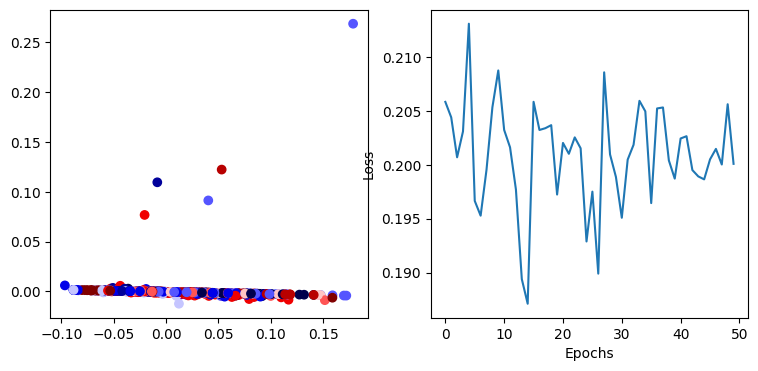

In [72]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=False,
    callbacks=[
        PCAPlotter(plt, embedding_model, X, Y)
    ]
)